### run metric on footprint of minisurveys

steps

- [get pixIds for each minisurvey](#get-pixIds-for-each-minisurvey)
- [run metric use UserPointSlicer](#run-metric-on-footprints-of-minisurveys)

Minisurveys includes

- 5 deep drilling fields
 
 - DD:COSMOS	proposalId=2, 	RA=150.1,	Dec=2.142726,	pixId=1467	1530
 - DD:ELAISS1	proposalId=3,	RA=9.48,	Dec=-44.0,	pixId=2593	2593
 - DD:ECDFS	    proposalId=4,	RA=53.149817,	Dec=-28.080352,	pixid=2217	2281
 - DD:EDFS		proposalId=5,   RA=61.284445,	Dec=-48.422251,	pixId=2602	2716
 - DD:XMM-LSS	proposalId=6,	RA=35.707074,	Dec=-4.723090,	pixId=1638	1638
  
- Magellanic Clouds
  - Large, RA=80.89375, Dec=-68.243889, size~ 10 degree
  - Small, RA=13.18666, Dec=-71.171389, size~ 5 degree
  
- galactic plane


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline

import healpy as hp

then run [utils](#utils) 

### get pixIds for each minisurvey

In [2]:
DBPATH_V1_5 = "/home/idies/workspace/lsst_cadence/FBS_1.5/"
COLS = 'night, observationStartMJD, fieldRA, fieldDec, filter, proposalId, note'
NSIDE = 64

In [5]:
# baseline
dbname =  'baseline_v1.5_10yrs.db'

# get some data from opsim database
df_opsim = get_cols(dbfile=DBPATH_V1_5 + dbname, cols=COLS)

# get healpix Ids
df_opsim = get_pixId(df_opsim, nside=NSIDE)

# in galactic coordinates
df_opsim['fieldGl'], df_opsim['fieldGb'] = radec2gal(ra=df_opsim['fieldRA'].values, dec=df_opsim['fieldDec'].values)



connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/baseline_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, fieldDec, filter, proposalId, note FROM SummaryAllProps


In [6]:
df_opsim.head(2)

,night,observationStartMJD,fieldRA,fieldDec,filter,proposalId,note,pixId,fieldGl,fieldGb
0,1,59853.985644,294.696105,4.470982,z,0,greedy,22609,42.39422,-8.421518
1,1,59853.986058,297.734708,3.424593,z,1,greedy,23123,42.92609,-11.585333


In [29]:
df_opsim.note.unique()

array(['greedy', 'blob, yy, a', 'blob, yy, b', 'DD:ELAISS1', 'DD:XMM-LSS',
       'DD:EDFS', 'blob, iz, a', 'blob, iz, b', 'blob, zy, a',
       'blob, zy, b', 'blob, ri, a', 'blob, ri, b', 'blob, gr, a',
       'blob, gr, b', 'DD:ECDFS', 'blob, ug, a', 'blob, ug, b',
       'blob, ur, a', 'blob, ur, b', 'DD:COSMOS'], dtype=object)

In [30]:
# get pixIds for five DD fields
pixId_DD_COSMOS =  df_opsim.pixId[ df_opsim.note.str.contains('DD:COSMOS') ].unique() 
pixId_DD_ELAISS1 =  df_opsim.pixId[ df_opsim.note.str.contains('DD:ELAISS1') ].unique() 
pixId_DD_ECDFS = df_opsim.pixId[ df_opsim.note.str.contains('DD:ECDFS') ].unique() 
pixId_DD_EDFS = df_opsim.pixId[ df_opsim.note.str.contains('DD:EDFS') ].unique() 
pixId_DD_XMM_LSS = df_opsim.pixId[ df_opsim.note.str.contains('DD:XMM-LSS') ].unique() 

print(pixId_DD_COSMOS, pixId_DD_ELAISS1, pixId_DD_ECDFS, pixId_DD_EDFS, pixId_DD_XMM_LSS)

[23530 23787 23786 23531 23275 24042] [41347 41346 41594 41838 41837 41593] [35749 36006 36261 36005 36262] [43028 42580 43247 42807 43462 43027 42348 42579 42808 43246 42804] [26521 26777 26265 26778 26266 26009 26520 27033]


#### Magellanic Clouds

##### select as a simple disk

In [117]:
#LMC
center = radec2xyz(ra=80.89375, dec=-68.243889)
radius = np.deg2rad(10/2) 
ipix_LMC_disk = hp.query_disc(NSIDE, center, radius, inclusive=True)

ipix_LMC_disk

array([2860, 2899, 2900, 2901, 2934, 2935, 2936, 2965, 2966, 2967, 2992,
       2993, 2994, 3016])

In [118]:
# SMC
center = radec2xyz(ra=13.18666, dec=-71.171389)
radius = np.deg2rad(5/2) 
ipix_SMC_disk = hp.query_disc(NSIDE, center, radius, inclusive=True)
ipix_SMC_disk

array([2929, 2960, 2961, 2988, 2989, 3012])

##### select by 12  fields give in MCs white paper

In [105]:
# select by 12 fields given in MC white paper

fields_SMC = pd.DataFrame()
fields_SMC['RA'] = [5.606889, 16.568751, 9.777261 ]
fields_SMC['Dec'] = [-73.293784, -72.896888, -70.757693 ]

fields_LMC = pd.DataFrame()
fields_LMC['RA'] = [72.000005, 81.777206,91.216696, 
                     76.364237, 84.972540, 93.230817, 
                     71.999949, 79.825808, 87.479642 ]

fields_LMC['Dec'] = [-70.933132, -70.757749, -70.227751,
                    -68.470535, -68.155026, -67.520318,
                    -66.069988, -65.928086, -65.499818 ]


In [7]:
def get_pixId_inFoV(fields, nside=16, fov=3.5, res=0.1):
    """get pixIds with field 3.5 deg, center (ra, dec), in degree"""
    ra = fields['RA']
    dec = fields['Dec']
    ra = np.arange(ra-fov/2, ra+fov/2, res)
    dec = np.arange(dec-fov/2, dec+fov/2, res)
    
    ra, dec = np.meshgrid(ra, dec)
    
    pixes = RADec2pix(ra=ra, dec=dec, nside=nside)

    return np.unique(pixes)


In [123]:
ipix_LMC = np.unique( np.concatenate ( fields_LMC.apply(get_pixId_inFoV, axis=1, nside=16, res=0.1).values,  ) )
ipix_SMC = np.unique( np.concatenate ( fields_SMC.apply(get_pixId_inFoV, axis=1, nside=16, res=0.1).values,  ) )


In [124]:
ipix_LMC

array([2899, 2900, 2901, 2934, 2935, 2936, 2965, 2966, 2967, 2992, 2993,
       2994])

In [125]:
ipix_SMC

array([2960, 2961, 2988, 2989, 3012])

#### galactic plane

In [8]:
def getAvoidanceLatitudes(galL, peakDeg=10., taperDeg=80., constWidth=5.):
    
    """Returns the (positive) GP avoidance region for input galactic longitude
    Input:
        galL: in degree
        peakDeg: galaxy peak size
        taperDeg: half width, in degree
        constWidth: in degree
    return 
        val: the positive galaxy b, in degree
    """  
    # The following is adapted from spatialPlotters.py in sims_maf, method _plot_mwZone
    
    # astropy uses 0 <= glon <= 2pi, so we shift the input values accordingly.
    galL = np.radians(galL)
    galL_use = np.copy(galL)
    gSec = np.where(galL_use > np.pi)
    galL_use[gSec] -= 2.0 * np.pi
    
    peakWidth=np.radians(peakDeg)
    taperLength=np.radians(taperDeg)
    val = peakWidth * np.cos(galL_use / taperLength * np.pi / 2.)
    
    # Remove the cosine peak at anticenter
    gFar = np.where(np.abs(galL_use) > taperLength)[0]
    val[gFar] = 0.

    val += np.radians(constWidth)
    
    return np.rad2deg(val)


In [9]:
# define the shape of galactic plane
peakDeg=15.
taperDeg=90.
constWidth=.5

# get the latitude of galaxy region
df_opsim['galaxyb'] = getAvoidanceLatitudes(df_opsim['fieldGl'].values, peakDeg, taperDeg, constWidth)

# check if a field is ingalaxy
df_opsim['ingalaxy'] = ( df_opsim['fieldGb'] > -df_opsim['galaxyb'] ) & ( df_opsim['fieldGb'] < df_opsim['galaxyb'] ) 

# get pixId in galactic plane
ipix_GP = df_opsim.pixId[df_opsim.ingalaxy].unique()



#### plot footprints 

In [10]:
df = df_opsim

# # DD fields
# df["inDD"] = df['note'].str.contains('DD')

# # LMC, SMC
# df['inLMC'] = np.isin(df['pixId'].values, ipix_LMC)
# df['inSMC'] = np.isin(df['pixId'].values, ipix_SMC)

# df['inLMC_disk'] = np.isin(df['pixId'].values, ipix_LMC_disk)
# df['inSMC_disk'] = np.isin(df['pixId'].values, ipix_SMC_disk)

# Galactic
df['galaxyb'] = getAvoidanceLatitudes(df['fieldGl'].values, peakDeg, taperDeg, constWidth)
df['ingalaxy'] = ( df['fieldGb'] > -df['galaxyb'] ) & ( df['fieldGb'] < df['galaxyb'] ) 



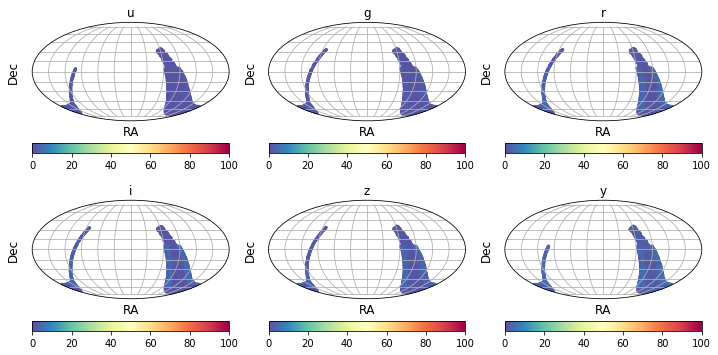

In [11]:

# slice required dataframe 
# Deep drilling

slicer = ( df['night'] < 1000 ) &( df['ingalaxy'])# | df['inLMC_disk'] | df['inSMC_disk'] | df['inDD']
df_ = df[slicer]
# groupby healpix
bydic = {
    "observationStartMJD": "count",
    "fieldRA" : "mean",
    "fieldDec": "mean",
    "fieldGl" : "min",
    "fieldGb": "min",
}
df_ = df_.groupby(by=['pixId','filter'], as_index=False).agg(bydic).rename(columns={"observationStartMJD": "Nv"})

plot_filter_Nv(df_, coord='C', figsize=(12, 6), vmax=100, s=5, cmap=plt.cm.Spectral_r)



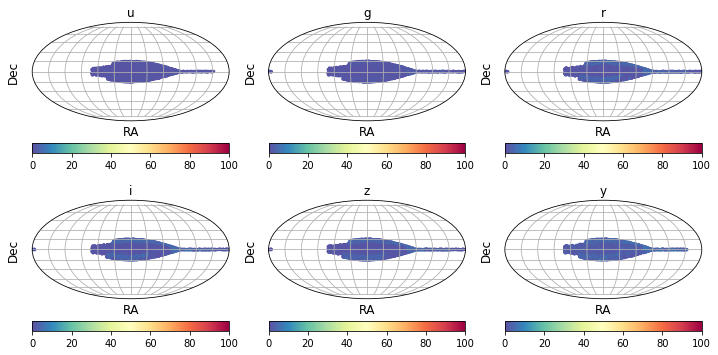

In [12]:
# in galactic plane
plot_filter_Nv(df_, coord='G', figsize=(12, 6), vmax=100, s=5, cmap=plt.cm.Spectral_r)


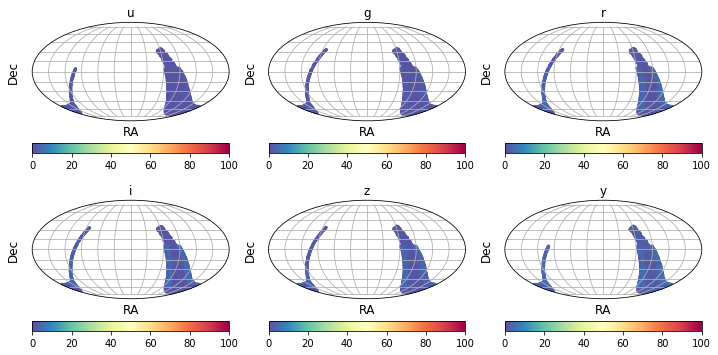

In [13]:

# slice required dataframe 
# Deep drilling

slicer = ( df['night'] < 1000 ) &( df['ingalaxy'])# | df['inLMC'] | df['inSMC'] | df['inDD']
df_ = df[slicer]
# groupby healpix
bydic = {
    "observationStartMJD": "count",
    "fieldRA" : "mean",
    "fieldDec": "mean",
    "fieldGl" : "min",
    "fieldGb": "min",
}
df_ = df_.groupby(by=['pixId','filter'], as_index=False).agg(bydic).rename(columns={"observationStartMJD": "Nv"})

plot_filter_Nv(df_, coord='C', figsize=(12, 6), vmax=100, s=5, cmap=plt.cm.Spectral_r)



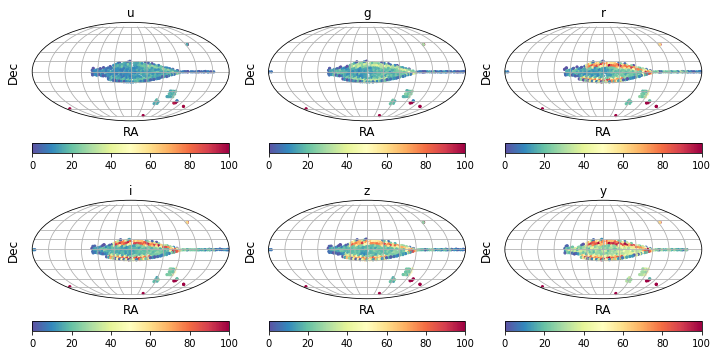

In [114]:
plot_filter_Nv(df_, coord='G', figsize=(12, 6), vmax=100, s=5, cmap=plt.cm.Spectral_r)


### run metric on footprints of minisurveys

In [14]:
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [29]:
# load opsim database
#dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.4/"  # path to all opsim databases
your_username = 'somayeh91'

run_name = 'bulges_cadence_i_heavy_v1.5_10yrs.db'
opSimDbs = '/home/idies/workspace/lsst_cadence/FBS_1.5/'+ run_name
opsdb = db.OpsimDatabase(opSimDbs)


if your_username == '':
    raise Exception('Please provide your username!  See the top of this notebook.')

# output directory
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/db_results_3_4_2021/'.format(your_username)
resultsDb = db.ResultsDb(outDir=outDir)


In [16]:
# # define metric here
class testMetric(metrics.BaseMetric):
    """simplest metric example"""
    def __init__(self, colname, **kwargs):
        self.colname = colname
        super().__init__(col=colname, metricDtype='float', **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        
        # method used to compute metric, return a float value for each slicepoint/healpix
        data = dataSlice
        if len(data)!=0:
            result = np.mean(data[self.colname])  
        else:
            result = hp.UNSEEN
        return result


In [17]:
sys.path.insert(0, '../sims_maf_contrib/')


from mafContrib import StarCountMetric, CampaignLengthMetric

In [33]:

# mini survey pixIds
# for 5 DDFs: pixId_DD_COSMOS, pixId_DD_ELAISS1, pixId_DD_ECDFS, pixId_DD_EDFS, pixId_DD_XMM_LSS
# for MCs: ipix_LMC, ipix_SMC
# for GP: ipix_GP
# to combine surveys: use np.concatenate([ pixId_DD_COSMOS, pixId_DD_ELAISS1, pixId_DD_ECDFS...] )
ipix_ms = ipix_GP

# metric, slicer, constraint
# metric = StarCountMetric()#testMetric(colname='airmass',)
# metric = CampaignLengthMetric()
metric = metrics.UniformityMetric()
# metric = metrics.cadenceMetrics.NRevisitsMetric()

# use UserPointsSlicer for MS
ra, dec = pix2radec(nside=64, ipix=ipix_ms)
slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
# sqlconstraint = 'filter = "r"'

# bundle
# StarCountGP = metricBundles.MetricBundle(metric, slicer, sqlconstraint, summaryMetrics=metrics.SumMetric())
UniformityGP = metricBundles.MetricBundle(metric, slicer, summaryMetrics=metrics.MedianMetric())

# group bundle
# bundleDict = {'StarCount':StarCountGP}
bundleDict = {'UniformityGP':UniformityGP}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb, verbose=True)

# run
group.runAll()
# group.plotAll(closefigs = False)


Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldDec', 'fieldRA'].
Found 2229448 visits
Running:  ['UniformityGP']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [34]:
from lsst.sims.utils import _healbin

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


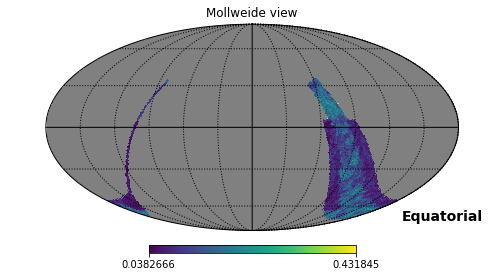

In [35]:
plt.figure(1)
dist = _healbin(slicer.slicePoints['ra'], slicer.slicePoints['dec'], StarCountGP.metricValues, nside=64)
hp.mollview(dist, fig=1, coord=['C'])
hp.graticule()

### utils

In [4]:
#  get columns from databases
def get_cols(dbfile, cols='night', lim=None):
    """
    cols = 'night, observationStartMJD, fieldRA, fieldDec, filter, proposalId, note'
    connect to database
    Returns: a pandas DataFrame
    
    Examples:
    
    cols = 'night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note, '

    df = get_cols(dbfile=dbpath + db, cols=cols, lim='night<300')
   
    """
    import sqlite3
    import pandas as pd
    connection = sqlite3.connect(dbfile)
    cursor = connection.cursor()
    
    if lim!=None:
        sqlstr = "SELECT {} FROM SummaryAllProps where {}".format(cols, lim)
    else:
        sqlstr = "SELECT {} FROM SummaryAllProps".format(cols)

    print('connect to ', dbfile, '\n', sqlstr)
    cursor.execute(sqlstr)
    data = cursor.fetchall()
    
    # convert data to dataframe
    data_df = pd.DataFrame(data, columns=cols.split(', '))
    
    # close connection
    connection.close()
    
    return data_df

def get_pixId(df, nside=16):
    '''get pixId for each field'''
    pixId = RADec2pix(nside, ra=df['fieldRA'].values, dec=df['fieldDec'].values)
    df['pixId'] = pixId
    return df

def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid

def radec2xyz(ra, dec):
    '''convert ra/dec to xyz'''
    theta = 0.5 * np.pi - np.deg2rad(dec)
    phi = np.deg2rad(ra)
    xyz = hp.ang2vec(theta, phi)
    
    return xyz

def radec2gal(ra, dec):
    '''convert from ra/dec to galactic l/b'''
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(ra=ra, dec=dec, 
                 unit=(u.degree, u.degree))
    
    l = c.galactic.l.degree
    b = c.galactic.b.degree
    return l, b

def gal2radec(gl, gb):
    '''convert gl/gb to ra/dec'''
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(l=gl, b=gb, frame="galactic",
                unit=(u.degree, u.degree))
    ra = c.icrs.ra.degree
    dec = c.icrs.dec.degree
    return ra, dec


# plot function
# plot skymap

def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmax=None, colorbar=True, **kwargs):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
        
    '''
    import numpy as np
    import matplotlib.pyplot as plt

    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=0, vmax=vmax, **kwargs)  # convert degrees to radians
    # ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)

def plot_filter_Nv(df, coord='C', figsize= (12, 6), colorbar=True, vmax=None, **kwargs):
    """plot number of visits in 6 filters"""
    
    fig, axs = plt.subplots(2, 3, figsize=figsize,
                            subplot_kw={'projection': 'mollweide'}); 
    axs = axs.ravel()
    FILTERS = ['u', 'g', 'r', 'i', 'z', 'y']
    for i, f in enumerate(FILTERS):
        
        df_f = df[ df['filter']==f ]
        if coord=='G':
            x = df_f['fieldGl'].values
            y = df_f['fieldGb'].values       
        else:
            x = df_f['fieldRA'].values
            y = df_f['fieldDec'].values
        c = df_f['Nv'].values
        if len(c)!=0:
            plot_mwd(axs[i], x, y, c, title=f, colorbar=colorbar, vmax=vmax, **kwargs)
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        axs[i].set_title(f)
